In [13]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q-utokyo", "internal", "hirashi-jst")
backend = provider.get_backend("ibmq_qasm_simulator")


ibmqfactory.load_account:WARNING:2023-06-11 18:25:50,410: Credentials are already in use. The existing account in the session will be replaced.


In [180]:
from qrao import QuantumRandomAccessEncoding, QuantumRandomAccessOptimizer, MagicRounding
from qiskit.utils import QuantumInstance
import networkx as nx
from qiskit_optimization.applications import Maxcut
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import NFT
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options
from qiskit.algorithms.minimum_eigensolvers import VQE
import matplotlib.pyplot as plt


In [181]:
# Parse the input CNF in the following manner:
# ex: 0 1 2,n0 1 2 => 0 1 2 3 1 2
def parse_cnf():
    num_variables = int(input("Enter the number of variables: "))
    cnf = input("Enter the CNF of the form above (ex: 0 1 2,0 n1 2): ")
    clauses = cnf.replace(",", " ")
    parsed_cnf = clauses.split(" ")
    for i in range(len(parsed_cnf)):
        if parsed_cnf[i].startswith("n"):
            parsed_cnf[i] = str(int(parsed_cnf[i][1:])+num_variables)
    parsed_cnf = list(map(lambda elem: int(elem), parsed_cnf))
    return parsed_cnf, num_variables

In [188]:
# the theoretical maxCut value is 1/2 * sumOfWeights + 1/2 * (C+M*|neg_var|)
def get_theoretical_cut_value(G, parsed_cnf, num_variables, M):
    cnf_contribution = -len(parsed_cnf)/3 # == -C
    variables = set(range(num_variables))
    for i in variables:
        if i in parsed_cnf and i + num_variables in parsed_cnf:
            cnf_contribution -= M
    weight_contribution = G.size(weight="weight")
    return 1/2 * weight_contribution - 1/2 * cnf_contribution


In [189]:
# Create a graph from an input CNF formula
# The weight of each edge (i,j) is 
# => num_triangles_that_share_that_edge if j != i+n
# => M otherwise
def create_maxcut_graph(parsed_cnf, num_variables, penalty_factor):
    
    cnf_variables = set(parsed_cnf)
    variables = set(range(num_variables))

    edge_weights = {}

    G = nx.Graph()
    vertices = list(cnf_variables)
    G.add_nodes_from(vertices)
    for i in range(0, len(parsed_cnf), 3):
        if (parsed_cnf[i], parsed_cnf[i+1]) in edge_weights:
            edge_weights[(parsed_cnf[i], parsed_cnf[i+1])] = edge_weights[(parsed_cnf[i], parsed_cnf[i+1])] + 1
        else:
            edge_weights[(parsed_cnf[i], parsed_cnf[i+1])] = 1

        if (parsed_cnf[i], parsed_cnf[i+2]) in edge_weights:
            edge_weights[(parsed_cnf[i], parsed_cnf[i+2])] = edge_weights[(parsed_cnf[i], parsed_cnf[i+2])] + 1
        else:
            edge_weights[(parsed_cnf[i], parsed_cnf[i+2])] = 1

        if (parsed_cnf[i+1], parsed_cnf[i+2]) in edge_weights:
            edge_weights[(parsed_cnf[i+1], parsed_cnf[i+2])] = edge_weights[(parsed_cnf[i+1], parsed_cnf[i+2])] + 1
        else:
            edge_weights[(parsed_cnf[i+1], parsed_cnf[i+2])] = 1
    
    for (u,v) in edge_weights.keys():
        G.add_edge(u, v, weight=edge_weights[(u,v)])


    for var in variables:
        if var in cnf_variables and var + num_variables in cnf_variables:
            G.add_edge(var, var+num_variables, weight=penalty_factor)    
    return G

In [199]:
# Compute the relaxed max cut using the protoype-qrao library
def compute_relaxed_max_cut(G, rounding_scheme, intermediate_results, should_round=False):
    maxcut = Maxcut(G)
    problem = maxcut.to_quadratic_program()
    encoding = QuantumRandomAccessEncoding(3)
    encoding.encode(problem)
    ansatz = EfficientSU2(encoding.num_qubits, reps=1)
    #vqe = VQEClient(ansatz, NFT(maxiter=24), provider=provider, backend=backend)
    service = QiskitRuntimeService()
    backend_str = "ibmq_qasm_simulator"
    results = None
    with Session(service=service, backend=backend_str) as session:
        options = Options()
        options.optimization_level = 3
        vqe = VQE(
            Estimator(session=session, options=options),
            ansatz,
            NFT(maxiter=96),
            callback= lambda c,p,v,m: intermediate_results.append(problem.objective.sense.value * (encoding.offset + v)) , #for now
        )
        qrao = QuantumRandomAccessOptimizer(encoding=encoding, min_eigen_solver=vqe, rounding_scheme=rounding_scheme)
        if not should_round:
            eigensolver_result, _ = qrao.solve_relaxed()
            # Relaxed MaxCut Value
            results = problem.objective.sense.value * (encoding.offset + eigensolver_result.eigenvalue.real)
        else:
            rounded_results = qrao.solve()
            results = rounded_results.x
    return results

In [200]:
parsed_cnf, num_variables = parse_cnf()
# example: 0 1 n2,2 n0 n5,n1 3 4,n3 n4 5
M = 20

G = create_maxcut_graph(parsed_cnf, num_variables, M)
rounding_scheme = MagicRounding(QuantumInstance(backend=backend, shots=1024))

In [202]:
G = create_maxcut_graph(parsed_cnf, num_variables, M)
rounding_scheme = MagicRounding(QuantumInstance(backend=backend, shots=1024))
theoretical_max_cut_value = get_theoretical_cut_value(G, parsed_cnf, num_variables, M)
print(f"Theoretical maxcut value : {theoretical_max_cut_value}")

intermediate_results = []
relaxed_max_cut_value = compute_relaxed_max_cut(G, rounding_scheme, intermediate_results, should_round=False)
print(f"Practical maxcut value: {relaxed_max_cut_value}")
if relaxed_max_cut_value < theoretical_max_cut_value:
    print("Not SAT-NAE")
else:
    print("Probably SAT-NAE")

Theoretical maxcut value : 128.0
Practical maxcut value: 156.13875
Probably SAT-NAE


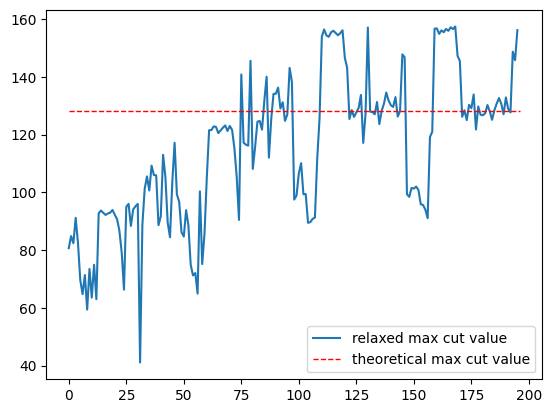

In [203]:
fig, ax = plt.subplots()
ax.plot(intermediate_results, label="relaxed max cut value")
ax.hlines(y=theoretical_max_cut_value, xmin=0, xmax=len(intermediate_results), linewidth=1, linestyles="--", color='r', label="theoretical max cut value")
plt.legend()

In [95]:
def calculate_error(parsed_cnf, num_variables, result):
    satnae_error = 0
    consistency_error = 0
    for i in range(len(parsed_cnf), 3):
        v1 = result[parsed_cnf[i]]
        v2 = result[parsed_cnf[i+1]]
        v3 = result[parsed_cnf[i+2]]
        if v1 + v2 + v3 == 3 or v1 + v2 + v3 == 0:
            satnae_error += 1
    
    for i in range(num_variables):
        if  i + num_variables < len(result) and result[i] == result[i+num_variables]:
            consistency_error += 1
    return satnae_error, consistency_error